# We are trying to understand how the Omega function works.

Ore used an approximation mentioned in https://arxiv.org/pdf/1904.07244.pdf Sec. 3.2 for the scattering of cells within a grid. 

We had created a script that worked for us, in which we assumed a spherical expansion. Due to this, we aligned the velocity vector with the radius vector such that

$\hat{\Omega}\equiv \hat{v} = \frac{\dot{\vec{r}}}{|\dot{\vec{r}}|}=\frac{\vec{r}}{|\vec{r}|}$. 

This made it such that our Omega function was defined in terms of position instead of velocity. 

This works, but makes it such that Omega can only be used for spherical outflows. Since the end goal is to learn how to do this with an HD GRB sim. frame, we need to generalize it such that it can take an arbitrary velocity vector and use this instead. 

This method should still work with a spherical outflow, but also with any other outflow with an arbitrary velocity field.

We first import the necessary libraries.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as unit
import astropy.constants as const
from matplotlib.patches import Rectangle
%matplotlib notebook

# 1. We first define our scattering functions.

We define 3 versions of Omega:

1. omega_v only takes input for velocity.

2. omega_r takes input for x,y components of radius vector and magnitude of radius vector itself.

3. omega_gamma takes input for x,y components of radius vector and magnitude of radius vector itself, with the inclusion of the Lorentz factor too.

We will compare the output of each one of these 3 methods of typing up the omega function.

Ideally, in our spherical outflow test, these should all output the same values.

In [3]:
def omega_v(v):
    '''
    Return $\hat{\Omega} = \dot{r}/|\dot{r}|$ in 2D. 
    This quantity is the unit first time derivative of the radius vector.
    
    INPUT: 
    
    --v (numpy array): 2D vector containing x,y components of 
    velocity vector.
    
    OUTPUT: 
    
    --omega (numpy array): 2D vector containing x,y components of 
    velocity unit vector.
    '''
    v_hat = v/np.linalg.norm(v)
    
    return v_hat

def omega_r(x,y,r):
    '''
    Return $\hat{\Omega} = \dot{r}/|\dot{r}|$ in 2D. 
    This quantity is the unit first time derivative of the radius vector.
    
    INPUT: 
    
    --x (float): x-component of position
    
    --y (float): y-component of position
    
    --r (float): radius
    
    OUTPUT: 
    
    --omega (numpy array): 2D vector containing x,y components of 
    velocity unit vector.
    '''
    v = np.array([x,y]) / r
    
    return v

def omega_gamma(x,y,r, gamma):
    '''
    Return $\hat{\Omega} = \dot{r}/|\dot{r}|$ in 2D. 
    This quantity is the unit first time derivative of the radius vector.
    
    INPUT: 
    
    --x (float): x-component of position
    
    --y (float): y-component of position
    
    --r (float): radius
    
    --gamma (float): Lorentz factor
    
    OUTPUT: 
    
    --omega (numpy array): 2D vector containing x,y components of 
    velocity unit vector.
    '''
    v = np.sqrt(1-1/gamma**2)*const.c.cgs.value*np.array([x,y])/r
    
    v = v/np.linalg.norm(v)
    
    return v

def s(t_sim, t, gamma = None):
    '''
    Return $s = v (t-t_{sim})$ in 2D. 
    This quantity is the step size the cell takes when moving at 
    speed $c$ or $v$ from time $t_{sim}$ to time $t$. 
    v argument is optional, if left as None, v = c is assumed.
    
    INPUT: 
    
    --t_sim (float): initial time
    
    --t (float): final time
    
    --v (float): speed
    
    OUTPUT: 
    
    --s float: magnitude of step taken in time $(t-t_{sim}})$ given by velocity $c$ or $v$.
    '''
    
    if gamma == None:
    
        s = (t-t_sim)*const.c.cgs.value
        
    else:
        
        s = (t-t_sim)*np.sqrt(1-1/gamma**2)*const.c.cgs.value
    
    return s

def r_step_c(r_i,s,omega_hat):
    '''
    Return $r = r_i + s \hat{\Omega}$ in 2D. 
    This quantity is the step size the cell takes when moving at 
    speed given by s from time $t_{sim}$ to time $t$
    
    INPUT: 
    
    --r_i (numpy array)
    
    --t_sim (float): initial time
    
    --t (float): final time
    
    OUTPUT: 
    
    --s float: magnitude of step taken in time $(t-t_{sim}})$
    '''
    r = r_i + s*omega_hat
    
    return r

# 2. We now test these different omega functions with a cell grid.

We will create a grid along the jet axis, whose radius is $\sim 10^{12}$ cm and whose cell size is $10^9$ cm.

<IPython.core.display.Javascript object>


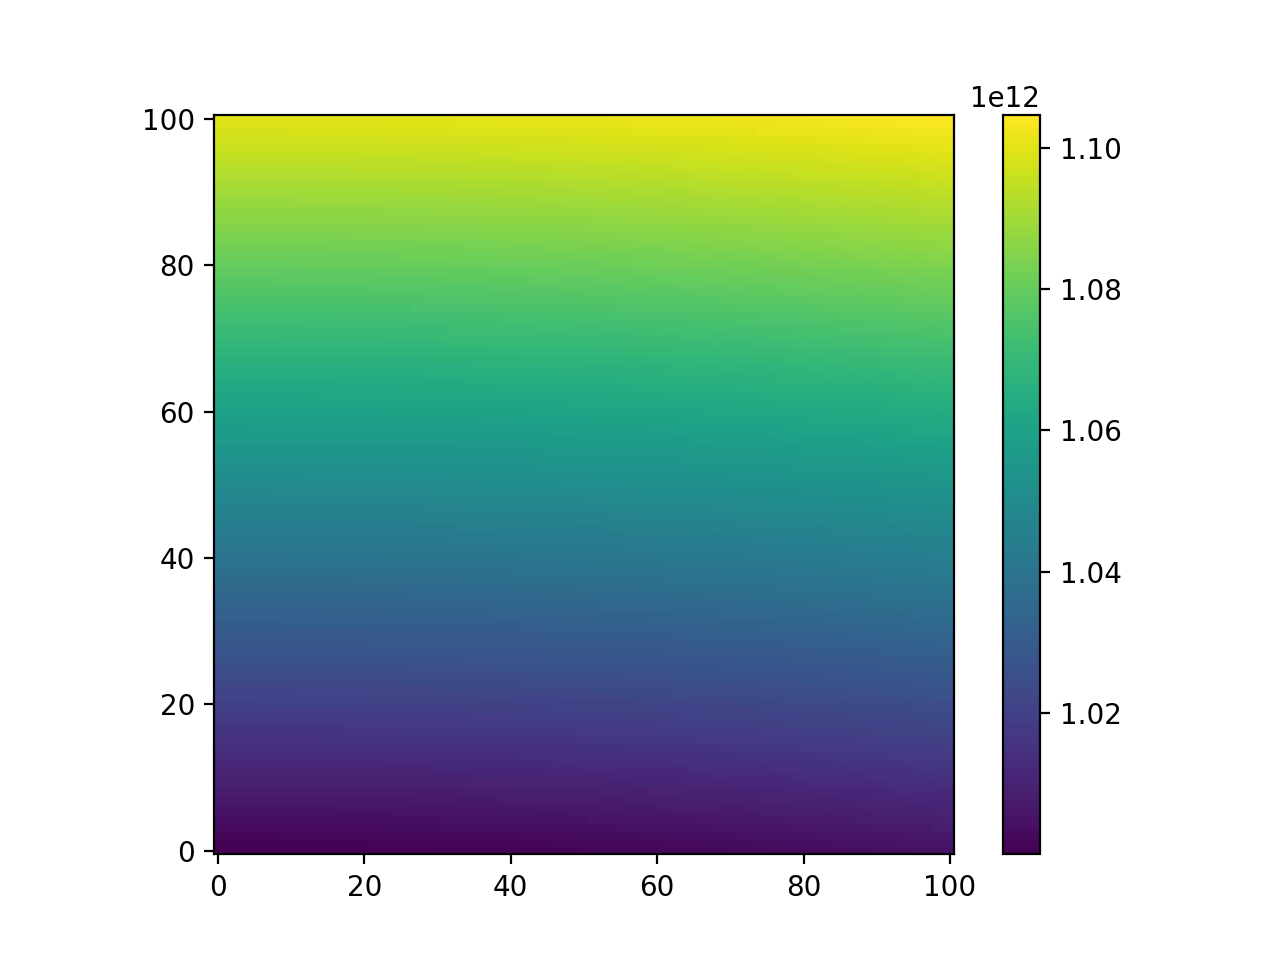

In [5]:
cell_size = 1e9

nx_jet_axis, ny_jet_axis = (101, 101) #number of steps
x_jet_axis = np.linspace(cell_size/2, cell_size/2 + 0.1e12, nx_jet_axis) #create x-interval of size 1e11
y_jet_axis = np.linspace(1e12, 1.1e12, ny_jet_axis) #create y-interval of size 1e11
xv_jet_axis, yv_jet_axis = np.meshgrid(x_jet_axis, y_jet_axis) #create 2D grid with x and y values

r0_jet_axis = np.sqrt(xv_jet_axis**2 + yv_jet_axis**2)

plt.imshow(r0_jet_axis, origin = 'lower')
plt.colorbar()

Since a spherical outflow's velocity vector is aligned with its position vector, technically we don't need any information about the Lorentz factor for the direction. 

That being said, omega_gamma takes the Lorentz factor as input. This is the function we had used in the past, which we know works. Therefore, in order to compare our other functions to this one, we need to populate the radius grid with spherical outflow properties.

The magnitude of the Lorentz factor does not matter in this case since Omega gets normalized into a unit vector.

In [7]:
def make_spherical_outflow( x, y, luminosity, gamma_infinity, r_0):
    r = np.sqrt(x**2+y**2)
    gg=np.zeros(r.shape)
    pp=np.zeros(r.shape)
    
    jj = np.where(r < (r_0 * gamma_infinity))
    kk = np.where(r >= (r_0 * gamma_infinity))

    if len(jj) > 0: 
        gg[jj] = r[jj] / r_0
    gg[kk] = gamma_infinity

    dd = (luminosity / 4 / np.pi / r ** 2 / const.c.cgs.value ** 3 / 
      gg / gamma_infinity)

    if jj[0].size > 0:
        pp[jj] = luminosity / 12 / np.pi / const.c.cgs.value * r_0 ** 2 / r[jj] ** 4
    pp[kk] = (luminosity / 12. / np.pi / const.c.cgs.value * 
      r_0 ** (2. / 3.) / gamma_infinity ** (4. / 3.) * (
      r[kk] ** ( -8. / 3.) ) )
    ee = 3 * pp
    return ee, gg, dd

In [8]:
energy_jet_axis, gamma_jet_axis, density_jet_axis = make_spherical_outflow(
  xv_jet_axis, yv_jet_axis, 1e54, 100, 1e11)

energy_jet_axis = energy_jet_axis/const.c.cgs.value**2

h_i_jet_axis = 1+ (4*energy_jet_axis)/(3*density_jet_axis)

We scatter the cells by $\Delta t$ = 10, 100, 200, 500 and 1000 s.

In [27]:
delta_t = [ 20 , 110 , 210 , 510 , 1010 ]

theta_grid = np.arctan(xv_jet_axis/yv_jet_axis)

new_radius_v = []

x_comps_v = []

y_comps_v = []

new_radius_r = []

x_comps_r = []

y_comps_r = []

new_radius_gamma = []

x_comps_gamma = []

y_comps_gamma = []


for t in range(len(delta_t)):
    
    empty_x_v = np.zeros(xv_jet_axis.shape)
    
    empty_y_v = np.zeros(yv_jet_axis.shape)
    
    empty_r_v = np.zeros(r0_jet_axis.shape)
    
    empty_x_r = np.zeros(xv_jet_axis.shape)
    
    empty_y_r = np.zeros(yv_jet_axis.shape)
    
    empty_r_r = np.zeros(r0_jet_axis.shape)
    
    empty_x_gamma = np.zeros(xv_jet_axis.shape)
    
    empty_y_gamma = np.zeros(yv_jet_axis.shape)
    
    empty_r_gamma = np.zeros(r0_jet_axis.shape)
    
    for i in range(len(r0_jet_axis)):

        for j in range(len(r0_jet_axis[i])):

            gamma = gamma_jet_axis[i][j]

            density = density_jet_axis[i][j]

            r_0 = r0_jet_axis[i][j]

            s_t = s(10,delta_t[t])

            
            omega_hat_v = omega_v(
              np.asarray([xv_jet_axis[i][j],yv_jet_axis[i][j]]))
            
            
            omega_hat_r = omega_r(
              xv_jet_axis[i][j],yv_jet_axis[i][j], r_0)
            
            
            omega_hat_gamma = omega_gamma(
              xv_jet_axis[i][j],yv_jet_axis[i][j], r_0,
              gamma)

            
            r_step_v = r_step_c(np.array([xv_jet_axis[i][j], 
              yv_jet_axis[i][j]]), s_t, omega_hat_v)
            
            
            r_step_r = r_step_c(np.array([xv_jet_axis[i][j], 
              yv_jet_axis[i][j]]), s_t, omega_hat_r)
            
            
            r_step_gamma = r_step_c(np.array([xv_jet_axis[i][j], 
              yv_jet_axis[i][j]]), s_t, omega_hat_gamma)

            
            r_f_v = np.linalg.norm(r_step_v)
            
            
            r_f_r = np.linalg.norm(r_step_r)
            
            
            r_f_gamma = np.linalg.norm(r_step_gamma)

            
            empty_x_v[i,j] = r_f_v*np.sin(theta_grid[i][j])

            empty_y_v[i,j] = r_f_v*np.cos(theta_grid[i][j])

            empty_r_v[i,j] = r_f_v
            
            
            empty_x_r[i,j] = r_f_r*np.sin(theta_grid[i][j])

            empty_y_r[i,j] = r_f_r*np.cos(theta_grid[i][j])

            empty_r_r[i,j] = r_f_r
            
            
            empty_x_gamma[i,j] = r_f_gamma*np.sin(theta_grid[i][j])

            empty_y_gamma[i,j] = r_f_gamma*np.cos(theta_grid[i][j])

            empty_r_gamma[i,j] = r_f_gamma
            
    x_comps_v.append(empty_x_v)
    
    y_comps_v.append(empty_y_v)
    
    new_radius_v.append(empty_r_v)
    
    
    x_comps_r.append(empty_x_r)
    
    y_comps_r.append(empty_y_r)
    
    new_radius_r.append(empty_r_r)
    
    
    x_comps_gamma.append(empty_x_gamma)
    
    y_comps_gamma.append(empty_y_gamma)
    
    new_radius_gamma.append(empty_r_gamma)

# 3. Having populated the scattered grids, we can plot them.

We first plot all of them (a lot of them).

<IPython.core.display.Javascript object>


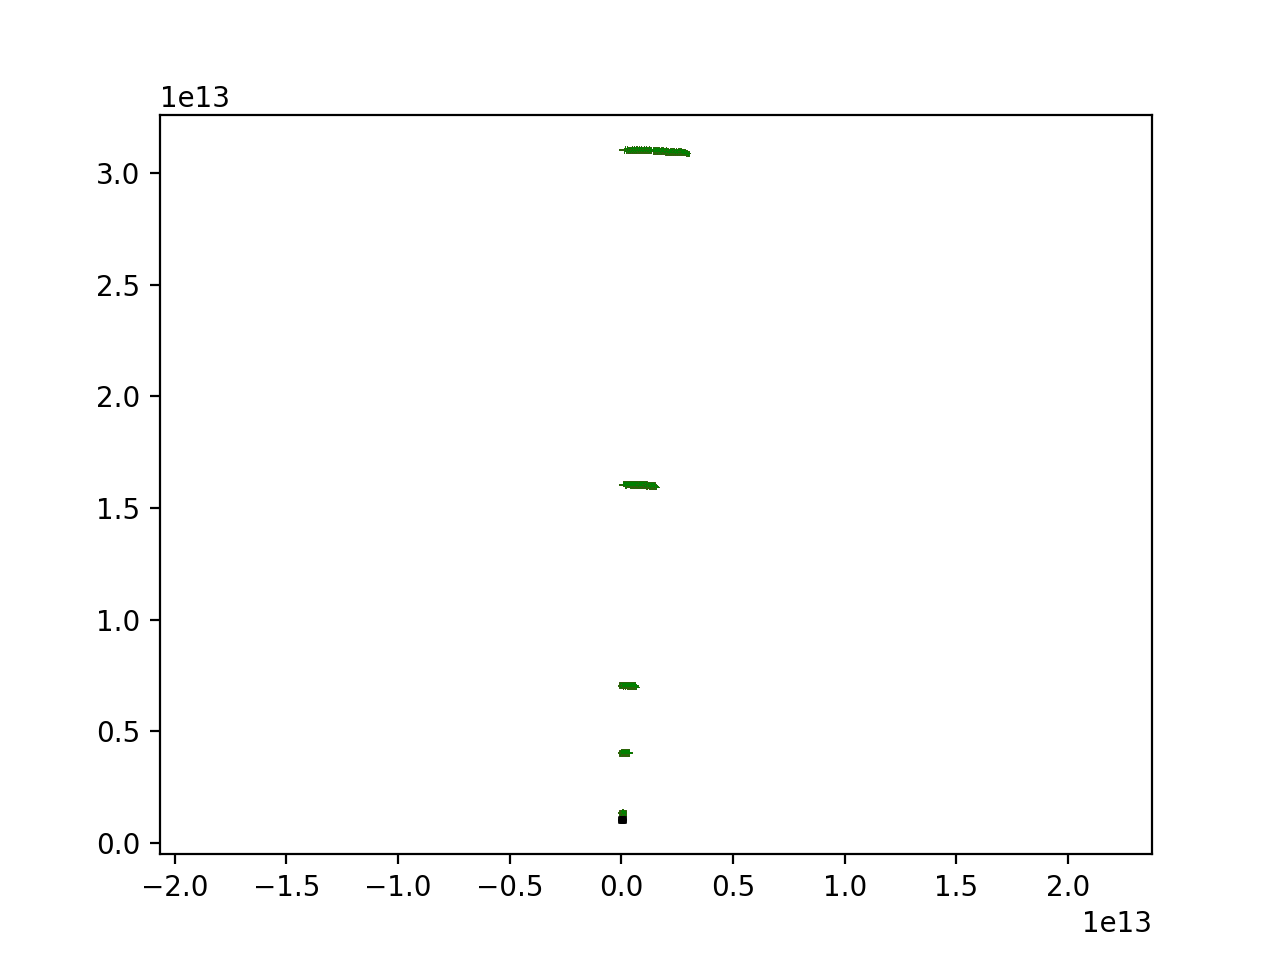

In [28]:
fig = plt.figure()

ax = plt.gca()

for i in range(len(xv_jet_axis)):
    
    for j in range(len(xv_jet_axis[0])):

        ax.add_patch(Rectangle((xv_jet_axis[i][j]-cell_size/2, 
          yv_jet_axis[i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='k', lw=2))
        
        ax.add_patch(Rectangle((x_comps_v[0][i][j]-cell_size/2, 
          y_comps_v[0][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='blue', lw=2))

        ax.add_patch(Rectangle((x_comps_v[1][i][j]-cell_size/2, 
          y_comps_v[1][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='blue', lw=2))

        ax.add_patch(Rectangle((x_comps_v[2][i][j]-cell_size/2, 
          y_comps_v[2][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='blue', lw=2))

        ax.add_patch(Rectangle((x_comps_v[3][i][j]-cell_size/2, 
          y_comps_v[3][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='blue', lw=2))

        ax.add_patch(Rectangle((x_comps_v[4][i][j]-cell_size/2, 
          y_comps_v[4][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='blue', lw=2))
        
        ax.add_patch(Rectangle((x_comps_r[0][i][j]-cell_size/2, 
          y_comps_r[0][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='red', lw=2))

        ax.add_patch(Rectangle((x_comps_r[1][i][j]-cell_size/2, 
          y_comps_r[1][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='red', lw=2))

        ax.add_patch(Rectangle((x_comps_r[2][i][j]-cell_size/2, 
          y_comps_r[2][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='red', lw=2))

        ax.add_patch(Rectangle((x_comps_r[3][i][j]-cell_size/2, 
          y_comps_r[3][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='red', lw=2))

        ax.add_patch(Rectangle((x_comps_r[4][i][j]-cell_size/2, 
          y_comps_r[4][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='red', lw=2))

        ax.add_patch(Rectangle((x_comps_gamma[0][i][j]-cell_size/2, 
          y_comps_gamma[0][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='green', lw=2))

        ax.add_patch(Rectangle((x_comps_gamma[1][i][j]-cell_size/2, 
          y_comps_gamma[1][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='green', lw=2))

        ax.add_patch(Rectangle((x_comps_gamma[2][i][j]-cell_size/2, 
          y_comps_gamma[2][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='green', lw=2))

        ax.add_patch(Rectangle((x_comps_gamma[3][i][j]-cell_size/2, 
          y_comps_gamma[3][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='green', lw=2))

        ax.add_patch(Rectangle((x_comps_gamma[4][i][j]-cell_size/2, 
          y_comps_gamma[4][i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='green', lw=2))

plt.axis('equal')

plt.show()

The issue was in calling the omega_v function. The function is well defined. The issue arises from giving it an argument of 

np.asarray(xv_jet_axis[0][0],yv_jet_axis[0][0])

instead of 

np.asarray([xv_jet_axis[0][0],yv_jet_axis[0][0]]).

As shown in the cells below, this causes a huge difference.

In [29]:
print(omega_v(np.asarray(xv_jet_axis[0][0],yv_jet_axis[0][0])))
print(np.asarray(xv_jet_axis[0][0],yv_jet_axis[0][0]))
print(xv_jet_axis[0][0],yv_jet_axis[0][0])

1.0
500000000.0
500000000.0 1000000000000.0


In [30]:
print(omega_v(np.asarray([xv_jet_axis[0][0],yv_jet_axis[0][0]])))
print(np.asarray([xv_jet_axis[0][0],yv_jet_axis[0][0]]))
print(xv_jet_axis[0][0],yv_jet_axis[0][0])

[4.99999938e-04 9.99999875e-01]
[5.e+08 1.e+12]
500000000.0 1000000000000.0
